In [12]:
import os
import glob
import sys
import warnings
import configparser

import pandas as pd
import numpy as np
import jax.numpy as jnp
from jax import lax, random, vmap
from jax.scipy.special import logsumexp
import flax
from flax.linen import *

import numpyro
from numpyro.distributions import constraints
import numpyro.distributions as dist
from numpyro.diagnostics import hpdi
from numpyro import handlers
from numpyro.infer.autoguide import AutoDiagonalNormal, AutoMultivariateNormal, AutoLaplaceApproximation, AutoDelta, AutoLowRankMultivariateNormal
from numpyro.infer import SVI, Trace_ELBO, Predictive, MCMC, NUTS
from numpyro.util import find_stack_level, not_jax_tracer
from tqdm.auto import trange, tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

sys.path.append('../src/')

# 図のテーマを設定
sns.set_theme(style="darkgrid", context="talk")
# Warningを非表示
warnings.filterwarnings("ignore")
# pandasの表示可能な幅を変更
pd.set_option("display.max_columns", 300)

rng_key = random.PRNGKey(1)
numpyro.set_platform('cpu')
numpyro.set_host_device_count(4)

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


- パラメータを一つしか持たない
- 平均と分散が等しい

$$
p(x)=\frac{\lambda^x e^{-\lambda}}{x!}
$$



## 野菜の収穫量データ



In [13]:
data = pd.DataFrame({
    'yield':[ 7, 13, 13, 11,  5,  6,  8, 11, 10, 11, 11, 11, 11, 14,  8, 15, 10,
        9, 13, 12,  8, 15,  7, 11,  5, 11, 15, 10, 13,  9,  8, 12, 13,  6,
        8,  5, 13,  8,  5, 10, 18,  9,  7, 12, 11,  5,  9, 10, 13, 13,  7,
       12,  8, 16, 10,  6, 12, 13, 10, 12,  9,  7, 12, 11,  8, 15, 13, 11,
        9, 17, 11, 10, 15, 19, 11, 13, 12,  9, 10, 10],
    'group':[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
})

y = data.query('group == 0')['yield'].values

In [14]:
data.sample(6)

,yield,group
60,9,1
12,11,0
13,14,0
18,13,0
3,11,0
26,15,0


In [15]:
def model(y=None, N=0):
    lam = numpyro.sample("lam", dist.HalfNormal(10))

    with numpyro.plate("data", N):
        numpyro.sample("obs", dist.Poisson(lam), obs=y)

nuts = NUTS(model)
mcmc = MCMC(nuts, num_warmup=1000, num_samples=5000, num_chains=4)

rng_key = random.PRNGKey(1)
mcmc.run(rng_key=rng_key, y=y, N=len(y))
samples = mcmc.get_samples()

idata = az.from_numpyro(mcmc)

sample: 100%|██████████| 6000/6000 [00:00<00:00, 7377.70it/s, 3 steps of size 9.93e-01. acc. prob=0.93]


In [18]:
idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

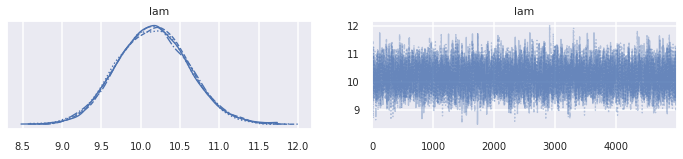

In [16]:
az.plot_trace(idata)
plt.show()

In [17]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
lam,10.16,0.451,9.301,10.984,0.005,0.004,7275.0,9588.0,1.0


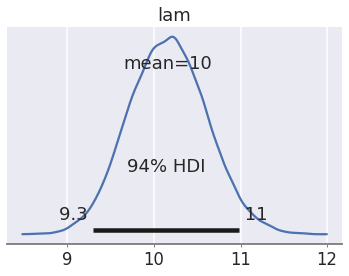

In [9]:
az.plot_posterior(idata)
plt.show()

## 事後予測分布の適合度合いを確認する

In [19]:
predictive = Predictive(model, samples)
ppc_samples = predictive(rng_key, N=len(y))

idata_ppc = az.from_numpyro(mcmc, posterior_predictive=ppc_samples)

In [21]:
ppc_samples["obs"].shape

(20000, 50)

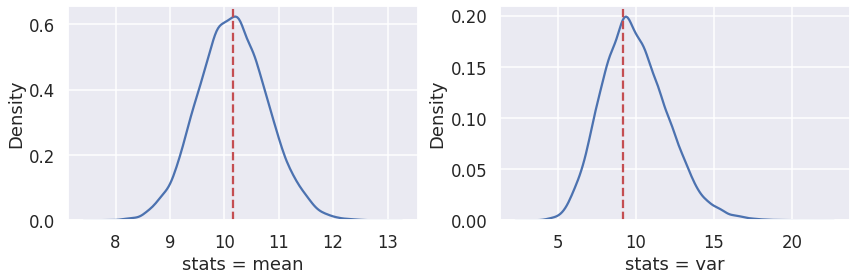

In [23]:
ppc_mean = ppc_samples['obs'].mean(axis=1)
ppc_var = ppc_samples['obs'].var(axis=1)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.kdeplot(ppc_mean, ax=axes[0])
axes[0].axvline(y.mean(), color='r', linestyle='dashed')
axes[0].set_xlabel('stats = mean')

sns.kdeplot(ppc_var, ax=axes[1])
axes[1].axvline(y.var(), color='r', linestyle='dashed')
axes[1].set_xlabel('stats = var')

plt.tight_layout()

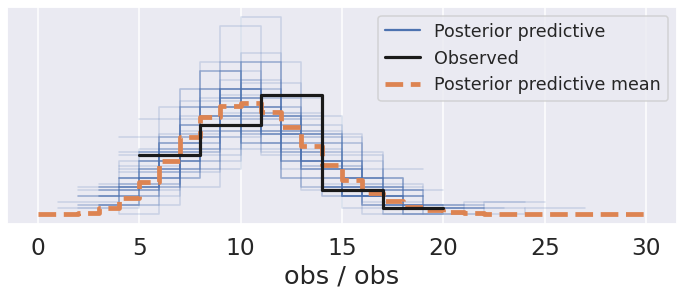

In [24]:
az.plot_ppc(idata_ppc, kind='kde', num_pp_samples=50, figsize=(12, 4));

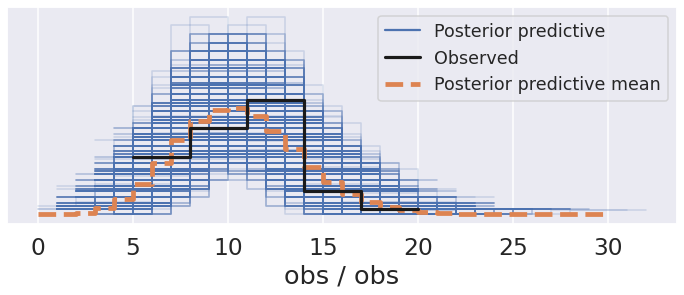

In [25]:
az.plot_ppc(idata_ppc, kind='kde', num_pp_samples=3000, figsize=(12, 4));

## ２つのポアソン分布を比較する

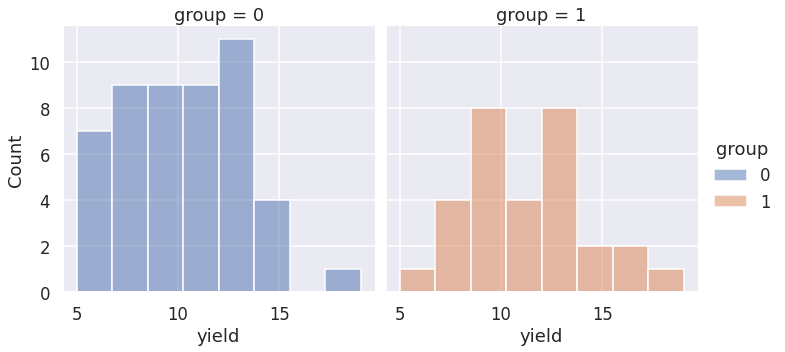

In [26]:
sns.displot(data=data, x='yield', hue='group', col='group');

In [27]:
y = data['yield'].values
g = data['group'].values

In [28]:
def model(y=None, g=None, N=0):
    lam = numpyro.sample('lam', dist.HalfNormal(10), sample_shape=(2,))
    
    lam_dup = lam[g]
    
    with numpyro.plate('data', N):    
        numpyro.sample('obs', dist.Poisson(lam_dup), obs=y)
    
    lam_diff = numpyro.deterministic('lam_diff', lam[1] - lam[0])

nuts = NUTS(model)
mcmc = MCMC(nuts, num_warmup=1000, num_samples=5000, num_chains=4)

mcmc.run(random.PRNGKey(1), y=y, g=g, N=len(y))

sample: 100%|██████████| 6000/6000 [00:01<00:00, 5606.43it/s, 3 steps of size 9.40e-01. acc. prob=0.90]


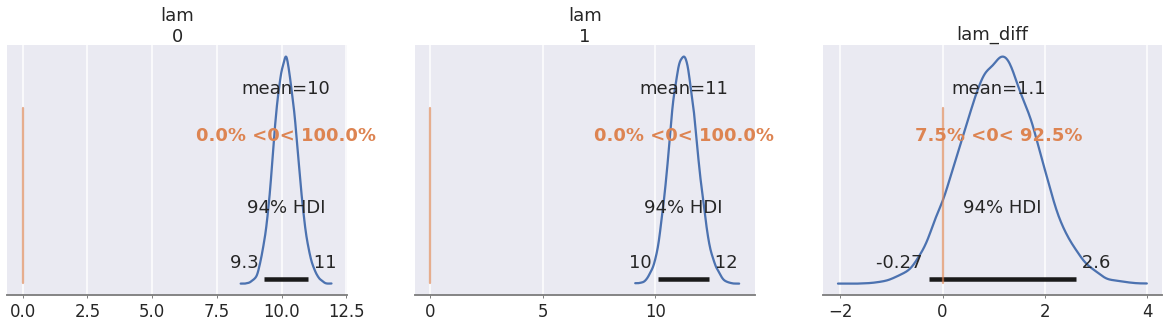

In [30]:
samples = mcmc.get_samples()
idata = az.from_numpyro(mcmc)
az.plot_posterior(idata, ref_val=0);